In [1]:
from IPython import get_ipython

# DICE SM - PRIM (recovered --> master)


   ## Setup & Initialisation of levers and uncertainties

In [2]:

import time
get_ipython().run_line_magic('matplotlib', 'inline')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('white')
import statsmodels.api as sm
from sklearn import preprocessing 
import ema_workbench.em_framework.evaluators


import os
from dest_directories import gz_path, fig_path
from dicemodel.specs import change_fontsize
from dicemodel.noDICE_v7 import PyDICE
model_version = 'v7'




In [3]:
from ema_workbench import (perform_experiments, Model, Policy, Scenario, ReplicatorModel, RealParameter, IntegerParameter, TimeSeriesOutcome, ScalarOutcome, ArrayOutcome, Constant, ema_logging, SequentialEvaluator, MultiprocessingEvaluator, IpyparallelEvaluator)
from ema_workbench import save_results, load_results

from ema_workbench.analysis import prim, cart
from ema_workbench.analysis import scenario_discovery_util as sdutil
from ema_workbench.analysis import pairs_plotting, plotting, plotting_util

import ema_workbench.em_framework.evaluators
from dicemodel.specs import change_fontsize
# from ema_workbench.analysis import feature_scoring
# from ema_workbench.em_framework.salib_samplers import get_SALib_problem
# from SALib.analyze import sobol

ema_logging.log_to_stderr(ema_logging.INFO)


<Logger EMA (DEBUG)>

In [4]:

if __name__ == '__main__':
    ema_logging.log_to_stderr(ema_logging.INFO)
    

    model = PyDICE()
    dice_sm = Model('dicesmEMA', function=model)
    
    dice_sm.uncertainties = [
                             RealParameter('tfp_gr',  0.07, 0.09),
                             RealParameter('sigma_gr', -0.012, -0.008),
                             RealParameter('pop_gr', 0.1, 0.15),
                             RealParameter('fosslim',  4000.0, 13649),
                             IntegerParameter('cback', 100, 600),
                             RealParameter('emdd', -0.1, 0.99),
                            ]
    
    dice_sm.levers = [RealParameter('sr', 0.1, 0.5),
                      RealParameter('prtp_con',  0.001, 0.015),
                      RealParameter('emuc',  1.01, 2.00),
                      IntegerParameter('vd_switch', 0, 1),
                      IntegerParameter('periodfullpart', 10, 58),
                      IntegerParameter('miu_period', 10, 58)
                      ]
    
    dice_sm.outcomes = [
                        TimeSeriesOutcome('Atmospheric Temperature'),
                        TimeSeriesOutcome('Total Output'),
                        TimeSeriesOutcome('Per Capita Consumption'),
                        TimeSeriesOutcome('Consumption Growth'),
                        TimeSeriesOutcome('Utility of Consumption'),
                        TimeSeriesOutcome('Per Capita Damage'),
                        TimeSeriesOutcome('Damage Growth'),
                        TimeSeriesOutcome('Disutility of Damage'),
                        TimeSeriesOutcome('Welfare'),
                        # TimeSeriesOutcome('Undiscounted Period Welfare'),
                        TimeSeriesOutcome('Consumption SDR'),
                        TimeSeriesOutcome('Damage SDR'),
                        TimeSeriesOutcome('SCC')
                        ]



In [5]:
n_scenarios = 2000
n_policies = 50
run = '30_OE'



In [6]:
## Load results
results = load_results(os.path.join(gz_path,'30_OE2000s_50p_.tar.gz'))
experiments, outcomes = results



[MainProcess/INFO] results loaded succesfully from E:\Year_2_Quarter_4\Thesis\06_Code\results\gz_files\30_OE2000s_50p_.tar.gz


In [7]:
# for x: Clean experiments (keep only levers, remove policy, scenario, model columns)
cleaned_experiments = experiments.drop(labels=[l.name for l in dice_sm.uncertainties], axis=1)
cleaned_experiments = experiments.drop(labels= ['policy', 'model',] , axis=1)
# type(cleaned_experiments)
# cleaned_experiments
x = cleaned_experiments
#  For y: outcomes is nd-array, PRIM needs 1D

In [8]:

# dropping first two steps (warm up) and last five steps(cooldown)
cleaned_outcome = {}
for key, value in outcomes.items():
    cleaned_outcome[key] = value[:,2:-5]  
cleaned_outcome['Welfare'].shape

(100000, 58)

In [9]:
# values for 2300 
end_outcome = {}
for key, value in outcomes.items():
    end_outcome[key] = value[:, -1]  

# np.mean(end_outcome['Damage Growth'], axis =0)


In [10]:
y = cleaned_outcome



In [11]:
y_welfare = end_outcome['Welfare'] < np.percentile(end_outcome['Welfare'], 10)


In [12]:

# the meaning of peel_alpha is the percentile of the data that is to be removed
# The peeling alpha determines how much data is peeled off in each iteration of the algorithm. The lower the value, the less data is removed in each iteration. Controls the leniency of the algorithm, the higher the less lenient.
# from ema_workbench.analysis import prim
x = cleaned_experiments
y = y_welfare

prim_alg = prim.Prim(x, y, threshold=0.5, peel_alpha=0.1) #0.1 



In [13]:
box1 = prim_alg.find_box()


[MainProcess/INFO] 100000 points remaining, containing 10000 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.05625, coverage: 0.5625, density: 1.0 restricted_dimensions: 4


In [14]:
box1.peeling_trajectory


,coverage,density,id,mass,mean,res_dim
0,1.0000,0.100000,0,1.00000,0.100000,0
1,1.0000,0.200000,1,0.50000,0.200000,1
2,1.0000,0.227273,2,0.44000,0.227273,2
3,1.0000,0.277778,3,0.36000,0.277778,2
4,1.0000,0.312500,4,0.32000,0.312500,2
5,1.0000,0.357143,5,0.28000,0.357143,2
6,1.0000,0.396825,6,0.25200,0.396825,3
7,1.0000,0.440917,7,0.22680,0.440917,3
8,1.0000,0.489908,8,0.20412,0.489908,3
9,1.0000,0.544425,9,0.18368,0.544425,3


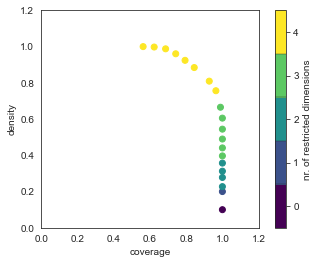

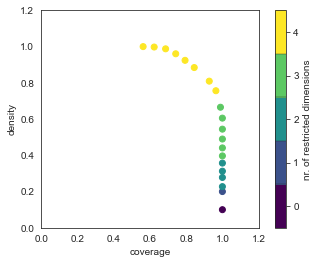

In [15]:
box1.show_tradeoff()


In [16]:
box1.inspect(13)


coverage      0.9275
density     0.809337
id                13
mass          0.1146
mean        0.809337
res_dim            4
Name: 13, dtype: object

               box 13                                           
                  min        max                       qp values
emdd        -0.099951   0.420299                     [-1.0, 0.0]
miu_period  34.000000  58.000000                     [0.0, -1.0]
vd_switch    0.500000   1.000000                     [0.0, -1.0]
sr           0.142786   0.497152  [8.560486100703134e-126, -1.0]



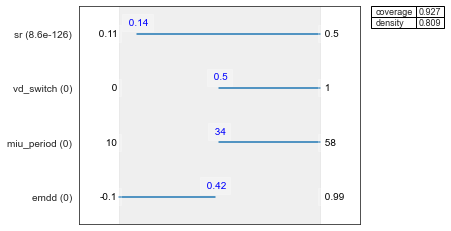

In [17]:
box1.inspect(13, style='graph')
plt.show()


In [19]:
box1.inspect(12)


coverage      0.9641
density     0.756513
id                12
mass         0.12744
mean        0.756513
res_dim            4
Name: 12, dtype: object

               box 12                                           
                  min        max                       qp values
emdd        -0.099951   0.478868                     [-1.0, 0.0]
miu_period  34.000000  58.000000                     [0.0, -1.0]
vd_switch    0.500000   1.000000                     [0.0, -1.0]
sr           0.142786   0.497152  [2.372474188954401e-111, -1.0]



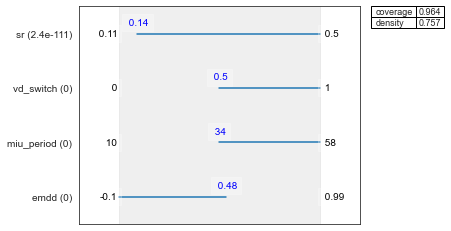

In [20]:
box1.inspect(12, style='graph')
plt.show()


In [21]:
box1.select(12)


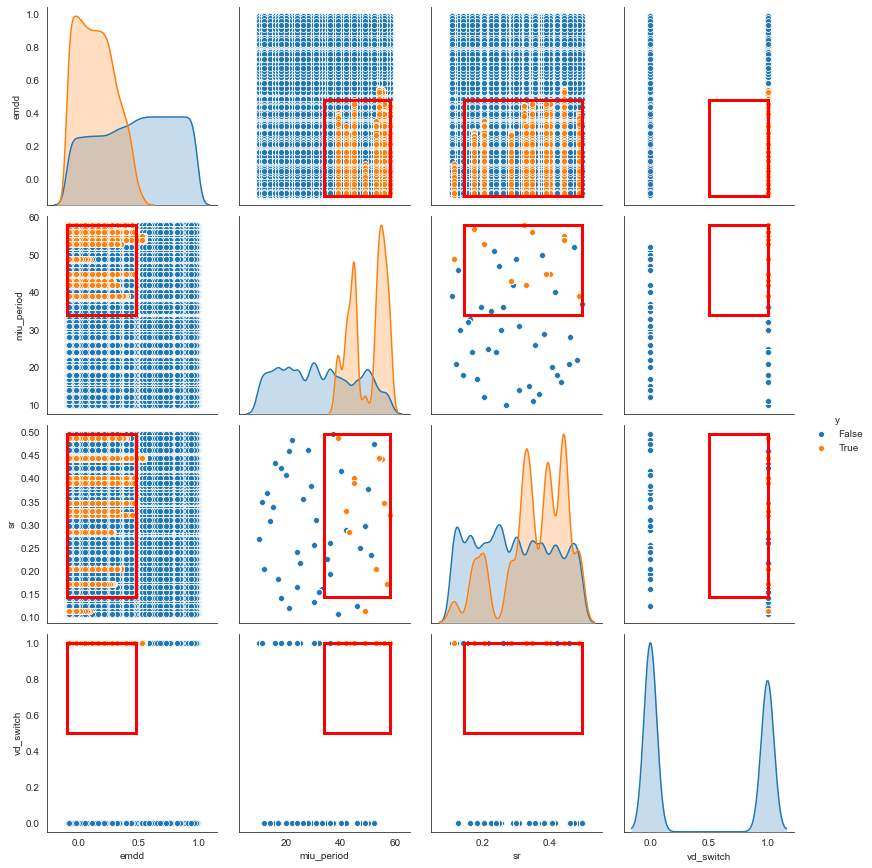

In [22]:
box1.show_pairs_scatter()
fig = plt.gcf()
fig.set_size_inches(12,12)
plt.show()


In [23]:
fig.savefig(os.path.join(fig_path,str(run) + '_PRIM_welfare_box1' + '.png'))


In [24]:
y_welfare = end_outcome['Welfare'] < np.percentile(end_outcome['Welfare'], 80)


In [25]:
y_welfare80 = end_outcome['Welfare'] < np.percentile(end_outcome['Welfare'], 80)


In [26]:
box2 = prim_alg.find_box()


[MainProcess/INFO] 87256 points remaining, containing 359 cases of interest
[MainProcess/INFO] box does not meet threshold criteria, value is 0.06241307371349096, returning dump box


In [27]:
box2.peeling_trajectory


,coverage,density,id,mass,mean,res_dim
0,0.0359,0.004114,0,0.87256,0.004114,0


In [29]:
box2.inspect()


coverage        0.0359
density     0.00411433
id                   0
mass           0.87256
mean        0.00411433
res_dim              0
Name: 0, dtype: object

Empty DataFrame
Columns: [(box 0, min), (box 0, max), (box 0, qp values)]
Index: []



In [30]:

# the meaning of peel_alpha is the percentile of the data that is to be removed
# The peeling alpha determines how much data is peeled off in each iteration of the algorithm. The lower the value, the less data is removed in each iteration. Controls the leniency of the algorithm, the higher the less lenient.
# from ema_workbench.analysis import prim
x = cleaned_experiments
y = y_welfare80

prim_alg = prim.Prim(x, y, threshold=0.5, peel_alpha=0.1) #0.1 



In [31]:
box1 = prim_alg.find_box()
box1.peeling_trajectory


[MainProcess/INFO] 100000 points remaining, containing 80000 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.64, coverage: 0.8, density: 1.0 restricted_dimensions: 1


,coverage,density,id,mass,mean,res_dim
0,1.000000,0.800000,0,1.00,0.800000,0
1,0.975000,0.866667,1,0.90,0.866667,1
2,0.935712,0.935712,2,0.80,0.935712,1
3,0.875000,0.972222,3,0.72,0.972222,1
4,0.800000,1.000000,4,0.64,1.000000,1


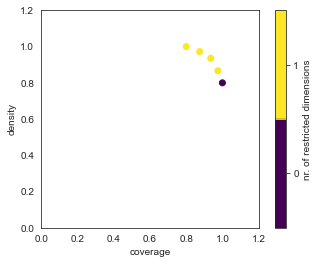

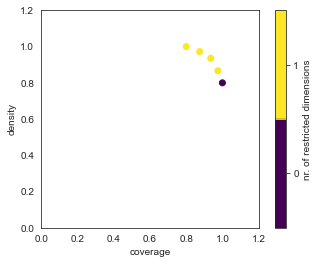

In [32]:
box1.show_tradeoff()


In [33]:
box1.inspect(2)


coverage    0.935712
density     0.935712
id                 2
mass             0.8
mean        0.935712
res_dim            1
Name: 2, dtype: object

         box 2                     
           min     max    qp values
emuc  1.211436  1.9832  [0.0, -1.0]



In [38]:
# Welfare
# y_welfare = end_outcome['Welfare'] < 5000
y_welfare20 = end_outcome['Welfare'] < np.percentile(end_outcome['Welfare'], 20)


In [39]:

# the meaning of peel_alpha is the percentile of the data that is to be removed
# The peeling alpha determines how much data is peeled off in each iteration of the algorithm. The lower the value, the less data is removed in each iteration. Controls the leniency of the algorithm, the higher the less lenient.
# from ema_workbench.analysis import prim
x = cleaned_experiments
y = y_welfare20

prim_alg = prim.Prim(x, y, threshold=0.5, peel_alpha=0.1) #0.1 



In [40]:
box1 = prim_alg.find_box()
box1.peeling_trajectory


[MainProcess/INFO] 100000 points remaining, containing 20000 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.11808, coverage: 0.5904, density: 1.0 restricted_dimensions: 4


,coverage,density,id,mass,mean,res_dim
0,1.00000,0.200000,0,1.00000,0.200000,0
1,1.00000,0.400000,1,0.50000,0.400000,1
2,1.00000,0.454545,2,0.44000,0.454545,2
3,1.00000,0.555556,3,0.36000,0.555556,2
4,1.00000,0.625000,4,0.32000,0.625000,2
5,1.00000,0.714286,5,0.28000,0.714286,2
6,0.98620,0.782698,6,0.25200,0.782698,3
7,0.93935,0.869769,7,0.21600,0.869769,4
8,0.89485,0.920628,8,0.19440,0.920628,4
9,0.77990,0.962840,9,0.16200,0.962840,4


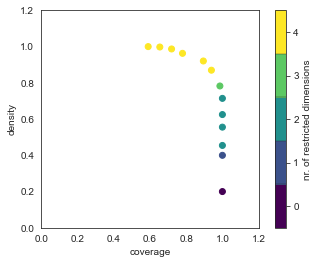

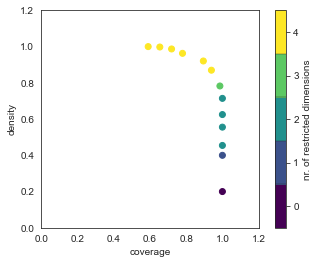

In [41]:
box1.show_tradeoff()


In [42]:

box1.inspect(8)

coverage     0.89485
density     0.920628
id                 8
mass          0.1944
mean        0.920628
res_dim            4
Name: 8, dtype: object

                box 8                                          
                  min        max                      qp values
emdd        -0.099951   0.782662                    [-1.0, 0.0]
miu_period  34.000000  58.000000                    [0.0, -1.0]
vd_switch    0.500000   1.000000                    [0.0, -1.0]
sr           0.142786   0.497152  [2.99911058759791e-295, -1.0]



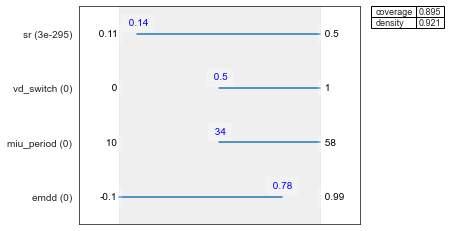

In [43]:
box1.inspect(8, style='graph')
plt.show()


In [44]:

box1.inspect(7)

coverage     0.93935
density     0.869769
id                 7
mass           0.216
mean        0.869769
res_dim            4
Name: 7, dtype: object

                box 7                                            
                  min        max                        qp values
emdd        -0.099951   0.881150  [-1.0, 1.2880945432641185e-184]
miu_period  34.000000  58.000000                      [0.0, -1.0]
vd_switch    0.500000   1.000000                      [0.0, -1.0]
sr           0.142786   0.497152  [1.2212146580563432e-237, -1.0]



In [45]:
box2 = prim_alg.find_box()


[MainProcess/INFO] 88192 points remaining, containing 8192 cases of interest
[MainProcess/INFO] mean: 0.9211768979295314, mass: 0.05506, coverage: 0.2536, density: 0.9211768979295314 restricted_dimensions: 5


In [46]:
box2.peeling_trajectory


,coverage,density,id,mass,mean,res_dim
0,0.40960,0.092888,0,0.88192,0.092888,0
1,0.40960,0.214495,1,0.38192,0.214495,1
2,0.40960,0.239588,2,0.34192,0.239588,2
3,0.40960,0.290579,3,0.28192,0.290579,2
4,0.40960,0.338624,4,0.24192,0.338624,2
5,0.40960,0.405705,5,0.20192,0.405705,2
6,0.40960,0.505929,6,0.16192,0.505929,2
7,0.40960,0.577227,7,0.14192,0.577227,3
8,0.40780,0.639085,8,0.12762,0.639085,4
9,0.39420,0.687059,9,0.11475,0.687059,4


In [47]:
box2.inspect()


coverage      0.2536
density     0.921177
id                14
mass         0.05506
mean        0.921177
res_dim            5
Name: 14, dtype: object

                   box 14                                           
                      min        max                       qp values
emdd            -0.099951   0.757789                     [-1.0, 0.0]
periodfullpart  10.000000  56.500000      [-1.0, 0.5127735603314563]
miu_period      37.500000  58.000000                     [0.0, -1.0]
vd_switch        0.500000   1.000000                     [0.0, -1.0]
sr               0.142786   0.497152  [1.0417481031993003e-59, -1.0]



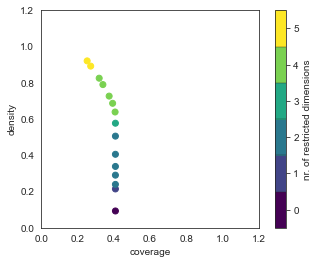

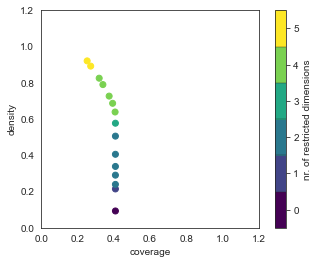

In [48]:
box2.show_tradeoff()


In [49]:
# Disutility of Damage
# what causes the values  of V(D) higher than 5 (from the violin plot, U(C) range never exceeds 4)
y_disutil_dam10 = end_outcome['Disutility of Damage'] > np.percentile(end_outcome['Disutility of Damage'], 10)
# y_disutil_dam = end_outcome['Disutility of Damage'] < np.percentile(end_outcome['Disutility of Damage'], 10)

###### by percentile
# #percentile < 80 = bottom 80

In [50]:

# the meaning of peel_alpha is the percentile of the data that is to be removed
# The peeling alpha determines how much data is peeled off in each iteration of the algorithm. The lower the value, the less data is removed in each iteration. Controls the leniency of the algorithm, the higher the less lenient.
# from ema_workbench.analysis import prim
x = cleaned_experiments
y = y_disutil_dam10

prim_alg = prim.Prim(x, y, threshold=0.5, peel_alpha=0.1) #0.1 



[MainProcess/INFO] 100000 points remaining, containing 50000 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.5, coverage: 1.0, density: 1.0 restricted_dimensions: 1


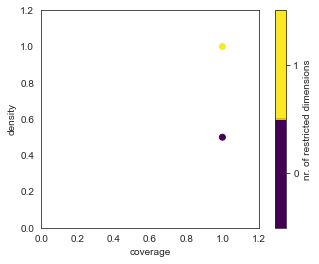

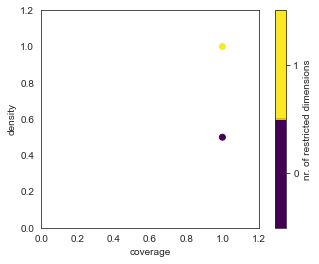

In [51]:
box1 = prim_alg.find_box()
box1.peeling_trajectory
box1.show_tradeoff()

In [52]:
box1.peeling_trajectory


,coverage,density,id,mass,mean,res_dim
0,1.0,0.5,0,1.0,0.5,0
1,1.0,1.0,1,0.5,1.0,1


In [54]:
box1.inspect(1)

coverage      1
density       1
id            1
mass        0.5
mean          1
res_dim       1
Name: 1, dtype: object

          box 1                  
            min  max    qp values
vd_switch   0.5  1.0  [0.0, -1.0]

